# Pauta obligatoria

La entrega debe ser prolija. Sólo se consideran válidos los puntos bien explicados con interpretación personal. No puede haber dos examenes iguales, para esto correremos un parseador de texto para comparar similaridad entre examenes.

El Examen termina 11 am.

# Campañas Online

Una empresa realiza campañas de marketing y posee el siguiente dataset.

**Descargue el dataframe y resuelva:**

https://drive.google.com/file/d/1aFIQO7evLxaUgM5A72ackExN0e6ZKuiS/view?usp=share_link

Descripción de variables:
-> id: id de la campaña
-> valor_de_yen: valor de la moneda yen expresado en otra moneda
-> plataforma : Plataforma de la campaña
	Google
	Facebook	Turbo
-> tipo_campaña : Objetivo de la cmapaña
	Conversion
	Branding
-> conv_rate : Tasa de conversion
-> clicks : Cantidad de clicks
-> type_of_ad : Tipo de anuncio
-> trend : Tendencia de la campaña. Meses que fue exitosa.
-> Cost_per_lead : Costo por lead. Es decir, por cliente que cotiza.
-> spend : Gasto total de la campaña.
-> exito_15 : Exito o no exito de la campaña dos semanas después.


In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
df=pd.read_parquet('campañas_oline.parquet', engine='pyarrow')

In [216]:
df.head()

,Cost_per_lead,Plataforma,clicks,conv_rate,exito_15,spend,tipo_campaña,trend,type_of_ad,id,valor_de_yen
0,2.68,Google,2548,64.1,Exito,5000,Conversion,four,Google,0,19
1,2.68,Google,2548,64.1,Exito,5000,Conversion,four,Google,1,11
2,3.47,Google,2823,65.5,Exito,5000,Conversion,six,Facebook,2,11
3,3.40,Google,2337,None,Exito,5500,Conversion,four,Instagram,3,11
4,3.40,Google,2824,66.4,Exito,5500,Conversion,five,Instagram,4,14


# 1. Evaluación del problema (15pts)
a. ¿Que tipo de modelo recomendaría?
b. Expliqué las razones del tipo de modelo de ML
c. Indique cuál es la variable independiente y dependiente.
d. ¿Cómo se utilizaría la predicción? ¿Que decisión tomaría la empresa?
e. Leyendo el nombre de las variables cuales variables te parece importante ¿Por qué?

In [217]:
df.dtypes

Cost_per_lead    float64
Plataforma        object
clicks             int64
conv_rate         object
exito_15          object
spend              int64
tipo_campaña      object
trend             object
type_of_ad        object
id                 int64
valor_de_yen       int64
dtype: object

¿porque la variable conv_rate es un object?

In [218]:
df.conv_rate.value_counts()

63.8    96
66.5    92
65.4    60
63.6    40
64.4    40
68.4    40
64      36
65.5    32
65.2    28
64.2    24
65.6    24
67.2    24
66.3    24
66.9    20
67.9    20
*       16
64.8    16
65.7    16
68.9    16
70.3    12
65      12
63.9    12
71.7    12
67.7     8
68.3     8
64.1     8
64.6     8
71.4     8
72.3     4
66.4     4
70.9     4
60.3     4
63.4     4
66.6     4
66.1     4
70.5     4
66       4
61.8     4
69.6     4
70.6     4
68       4
72       4
68.8     4
Name: conv_rate, dtype: int64

entre los valores de la tasa de conversión se encuentra un * Por lo tanto, lo reemplazo por nulos

In [219]:
df.conv_rate.replace('*',np.nan,inplace=True)
df.conv_rate=pd.to_numeric(df.conv_rate)

Ahora si, podría considerar esta columna como mi variable Y.Por otro lado, tengo la varaibale de exito_15

In [220]:
df.exito_15.value_counts()

No Exito             412
Exito                407
No Exito No Exito      1
Name: exito_15, dtype: int64

Esta variable es binaria de SI o NO por lo que podría implementar un modelo de regresión logistica para predecir el exito de la campaña
Voy a elegir hacer un modelo sobre la tasa de conversión ya que brinda mas información para tomar una desición que si tuvo exito o no. Ademas, al no saber quien creo este datset , no se que metricas tomo para decidir si fue un exito o  no la campaña

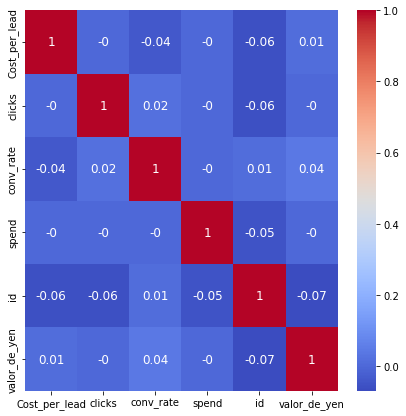

In [221]:
plt.figure(figsize = (7,7))
sns.heatmap(round(df.corr(),2), cmap = "coolwarm", annot = True, annot_kws = {"size":12});

In [222]:
df.columns

Index(['Cost_per_lead', 'Plataforma', 'clicks', 'conv_rate', 'exito_15',
       'spend', 'tipo_campaña', 'trend', 'type_of_ad', 'id', 'valor_de_yen'],
      dtype='object')

In [223]:
feauters=['Plataforma','Cost_per_lead','clicks','spend','tipo_campaña','trend','type_of_ad']

Las variables que creeria que  son impostantes son las de feauters.La variable del precio en yen , muestra una correlación en el heatmap pero como nose de que otra moneda habla , no la voy a usar

# 2. Preprocesamiento (30 pts)
a. Analizar faltantes variable a variable. Elegir métodos de imputación o tomar decisiones de dropearlos
b. Analizar valores outliers y repetir el analisis

In [224]:
def percentageOfnull(df):
    nan_count = df.isna().sum().sort_values(ascending=False)
    nan_percentage = ((df.isna().sum()/df.isna().count())*100).sort_values(ascending=False)
    train_test_dtype = df.dtypes
    df_info = pd.concat([nan_count,nan_percentage,train_test_dtype],axis=1,keys=['Null Count','Null Percentage','DataTypes'])
    return df_info[df_info['Null Count']>0]
percentageOfnull(df)

,Null Count,Null Percentage,DataTypes
tipo_campaña,40,4.878049,object
conv_rate,24,2.926829,float64


La variable tipo_de campaña tiene casi 5% de nulos.Voy a a nalizar los cuartiles y las caracteristicas de las campañas a ver si puedo reemplazar los nulos por datos

In [225]:
df.loc[df.tipo_campaña.isnull()]

,Cost_per_lead,Plataforma,clicks,conv_rate,exito_15,spend,tipo_campaña,trend,type_of_ad,id,valor_de_yen
14,3.19,Google,10000000,66.9,Exito,4250,None,six,Instagram,14,14
18,3.03,Google,1488,60.3,No Exito,5100,None,three,Youtube,18,12
54,3.15,Google,1950,64.2,No Exito,5000,None,four,Instagram,54,18
68,3.64,Facebook,3750,70.3,Exito,4350,None,five,Instagram,68,10
106,3.27,Google,3139,67.9,Exito,5200,None,six,Facebook,106,13
113,2.19,Google,3285,68.4,Exito,5000,None,four,Youtube,113,19
139,2.64,Google,2120,63.6,No Exito,4400,None,four,Linkedin,139,10
165,3.08,Google,2265,64.0,No Exito,6600,None,four,Google,165,11
186,3.40,Google,2275,65.5,No Exito,5250,None,four,Instagram,186,19
196,3.15,Google,2935,67.2,Exito,5400,None,four,Instagram,196,19


In [226]:
df.loc[df.tipo_campaña=='Branding']

,Cost_per_lead,Plataforma,clicks,conv_rate,exito_15,spend,tipo_campaña,trend,type_of_ad,id,valor_de_yen
126,2.9,Google,2756,65.0,Exito,5900,Branding,six,Linkedin,126,19
127,2.9,Google,2756,65.0,Exito,5900,Branding,six,Linkedin,127,11
128,2.9,Google,2800,65.0,Exito,5900,Branding,six,Linkedin,128,12
237,2.9,Google,2888,65.0,Exito,5917,Branding,six,Linkedin,237,12
310,2.9,Google,2816,65.0,Exito,5925,Branding,six,Linkedin,310,11
330,2.9,Google,2760,65.0,Exito,5920,Branding,six,Linkedin,330,19
415,2.9,Google,2847,65.0,Exito,5993,Branding,six,Linkedin,415,18
452,2.9,Google,2911,65.0,Exito,5984,Branding,six,Linkedin,452,16
622,2.9,Google,2795,65.0,Exito,5935,Branding,six,Linkedin,622,19
659,2.9,Google,2901,65.0,Exito,5933,Branding,six,Linkedin,659,18


No existen campañas de branding en plataformas fuera de google.Por lo tanto, podría imputar los nulos de los que no son google a tipo conversion y el resto lo eliminos

In [227]:
df.loc[df.Plataforma=='Google'].tipo_campaña.replace(np.nan,'Conversion')

0      Conversion
1      Conversion
2      Conversion
3      Conversion
4      Conversion
          ...    
813    Conversion
815    Conversion
816    Conversion
818    Conversion
819    Conversion
Name: tipo_campaña, Length: 672, dtype: object

In [228]:
df.tipo_campaña=df.tipo_campaña.dropna()

In [229]:
df.conv_rate=df.conv_rate.dropna()

Al ser con_rate mi variable independiente, voy a eliminar los nulos para no ensusiar el modelo.


OUTLIERS

In [230]:
df1=df[feauters]
df1.head()

,Plataforma,Cost_per_lead,clicks,spend,tipo_campaña,trend,type_of_ad
0,Google,2.68,2548,5000,Conversion,four,Google
1,Google,2.68,2548,5000,Conversion,four,Google
2,Google,3.47,2823,5000,Conversion,six,Facebook
3,Google,3.40,2337,5500,Conversion,four,Instagram
4,Google,3.40,2824,5500,Conversion,five,Instagram


In [231]:
df1.describe()

,Cost_per_lead,clicks,spend
count,8.200000e+02,8.200000e+02,8.200000e+02
mean,1.219515e+06,1.479542e+04,1.735482e+04
std,3.492151e+07,3.491246e+05,3.490351e+05
min,2.070000e+00,1.488000e+03,0.000000e+00
25%,3.110000e+00,2.204000e+03,4.850000e+03
50%,3.290000e+00,2.486000e+03,5.200000e+03
75%,3.410000e+00,2.979500e+03,5.501000e+03
max,1.000000e+09,1.000000e+07,1.000000e+07


In [232]:
df1.clicks.nlargest()

14     10000000
613        4181
796        4141
412        4133
300        4124
Name: clicks, dtype: int64

In [233]:
df1= df1[df1["clicks"]<df1["clicks"].max()]

In [234]:
df1.Cost_per_lead.nlargest()

24     1.000000e+09
47     4.170000e+00
48     4.170000e+00
300    4.170000e+00
343    4.170000e+00
Name: Cost_per_lead, dtype: float64

In [235]:
df1.spend.nlargest()


55     10000000
610        6715
616        6687
479        6646
307        6637
Name: spend, dtype: int64

In [236]:
df1= df1[df1["spend"]<df1["spend"].max()]

In [237]:
numerics= df1.select_dtypes(exclude=['object']).columns

In [238]:
numerics= df1.select_dtypes(exclude=['object']).columns

# 3. Ploteo y escalado (20 pts)
a. Plotear y analizar distribuciones.
b. Elegir un método de escalado

<AxesSubplot:ylabel='Frequency'>

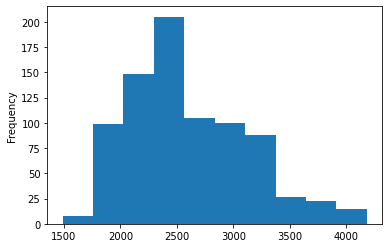

In [239]:
df1.clicks.plot.hist()

Tomo  esta variablke como normal(masomenos), sin outliers , por lo que uso standard

In [240]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df1['clicks'] = scaler.fit_transform(df1[['clicks']])
df1

,Plataforma,Cost_per_lead,clicks,spend,tipo_campaña,trend,type_of_ad
0,Google,2.68,-0.107078,5000,Conversion,four,Google
1,Google,2.68,-0.107078,5000,Conversion,four,Google
2,Google,3.47,0.421128,5000,Conversion,six,Facebook
3,Google,3.40,-0.512356,5500,Conversion,four,Instagram
4,Google,3.40,0.423049,5500,Conversion,five,Instagram
...,...,...,...,...,...,...,...
815,Google,3.47,0.547897,5083,Conversion,six,Facebook
816,Google,3.15,0.764942,5439,NaN,four,Instagram
817,Facebook,3.46,-0.274183,5535,Conversion,four,Instagram
818,Google,3.15,-1.201905,5010,Conversion,four,Instagram


<AxesSubplot:ylabel='Frequency'>

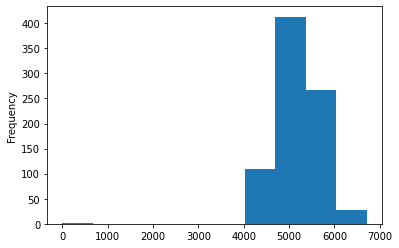

In [241]:
df1.spend.plot.hist()

<AxesSubplot:title={'center':'Boxplot despend'}, xlabel='spend'>

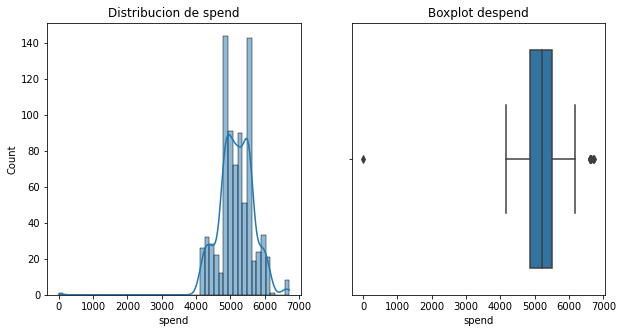

In [242]:
variable = 'spend'

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title(f"Distribucion de {variable}")
sns.histplot(data = df1, x = f"{variable}", kde=True, ax = ax[0])

ax[1].set_title(f"Boxplot de{variable}")
sns.boxplot(data = df1, x = f"{variable}", ax=ax[1])

Tomo esta variable como normal con outliers por lo que uso robust scaler

In [243]:
from sklearn.preprocessing import RobustScaler

rb_scaler = RobustScaler()
df1['spend']= rb_scaler.fit_transform(df1[['spend']])
df1.head()

,Plataforma,Cost_per_lead,clicks,spend,tipo_campaña,trend,type_of_ad
0,Google,2.68,-0.107078,-0.307574,Conversion,four,Google
1,Google,2.68,-0.107078,-0.307574,Conversion,four,Google
2,Google,3.47,0.421128,-0.307574,Conversion,six,Facebook
3,Google,3.40,-0.512356,0.461361,Conversion,four,Instagram
4,Google,3.40,0.423049,0.461361,Conversion,five,Instagram


# 5. Variables categoricas (15 pts)
a. Convertir variables categoricas a númericas, aplicar alguna de las tecnicas que vimos.

In [244]:
cat= df1.select_dtypes('object').columns
cat

Index(['Plataforma', 'tipo_campaña', 'trend', 'type_of_ad'], dtype='object')

In [245]:
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder(sparse=False)
ohe.fit(df1[['Plataforma']])
display(ohe.get_feature_names_out())
plataforma_encoded=ohe.transform(df1[['Plataforma']])
df1[ohe.get_feature_names_out()]=plataforma_encoded
df1.drop(columns='Plataforma',inplace=True)


array(['Plataforma_Facebook', 'Plataforma_Google'], dtype=object)

EN meses lo pasaria a numero con una función y  lo paso a fprmato fecha.Al tipo de campaña le haria un one hot encoder de tipo binario ya que son solo dos campañas.


al ser una variable de mas de una categotia utlizio el one hot encoder multi categorico

# 6. Modelo base (20 pts)
a. Crear un modelo simple
b. Crear una matriz de confusión.  (Interpretar)
c. Evaluar rendimiento con una métrica